In [53]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from scipy.stats import zscore


In [3]:
# Load the physiological data from the Oura Ring
oura_data = pd.read_csv("../Studies/oura_feats_bin01_23.csv")
# Load the MBSS score data
mbss_data = pd.read_csv("../Studies/mbss_scores.csv")

In [13]:
# Calculate the change in MBSS scores for each participant
mbss_pivot = mbss_data.pivot(index='ID', columns='Time Point', values=['EE Total Score', 'DP Total Score', 'PA Total Score'])
mbss_changes = mbss_pivot.xs('Follow Up', level='Time Point', axis=1) + mbss_pivot.xs('Baseline', level='Time Point', axis=1)
# mbss_changes = mbss_pivot.xs('Baseline', level='Time Point', axis=1)

# Calculate the mean of the physiological features across the time series for each participant
oura_summary = oura_data.groupby('participant_id').mean()

# Merge the MBSS changes with the physiological summary data
merged_data = pd.merge(mbss_changes, oura_summary, left_index=True, right_on='participant_id')

# Clean the data by removing NaNs
cleaned_merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()

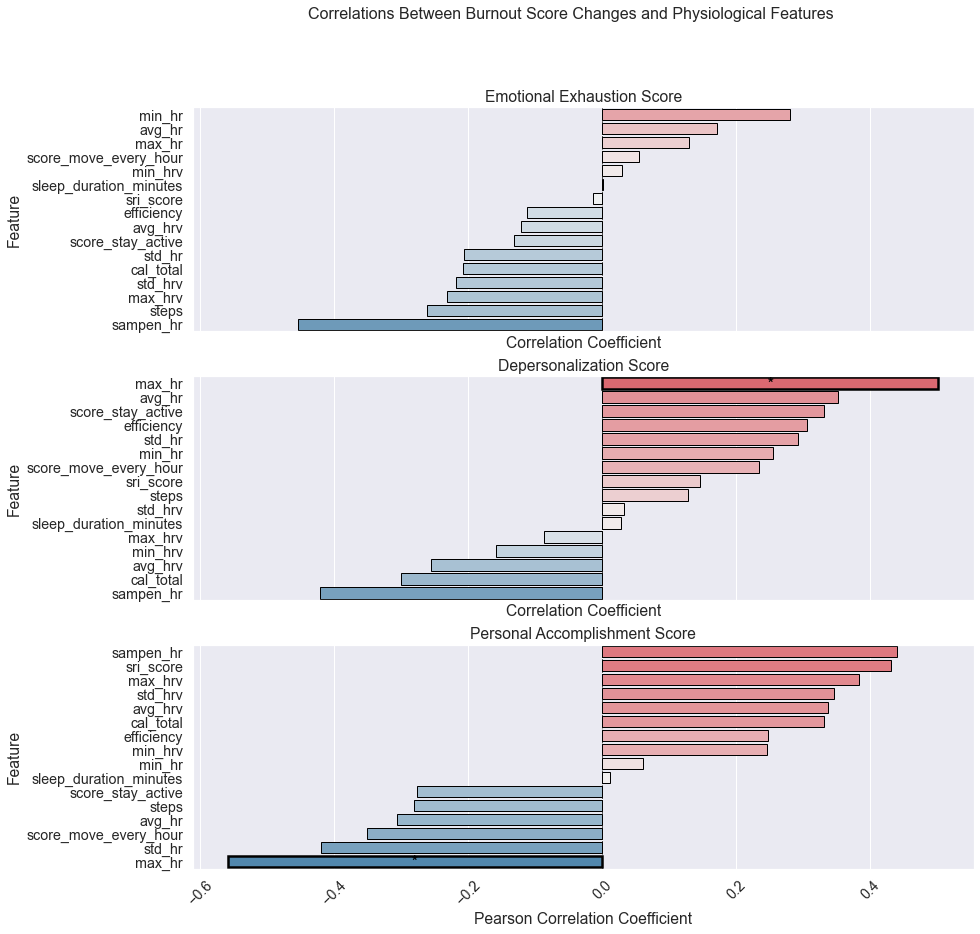

In [38]:
score_change_dict = {"EE": "Emotional Exhaustion", "DP": "Depersonalization", "PA": "Personal Accomplishment"}

# Perform the correlation analysis
correlation_results = {}
for score_type in ['EE Total Score', 'DP Total Score', 'PA Total Score']:
    correlation_results[score_type] = {}
    for feature in oura_summary.columns:
        corr_coefficient, p_value = stats.pearsonr(cleaned_merged_data[score_type], cleaned_merged_data[feature])
        correlation_results[score_type][feature] = (corr_coefficient, p_value)

# Prepare the data for visualization
correlation_data = []
for score_change, features in correlation_results.items():
    for feature, (corr_coefficient, p_value) in features.items():
        correlation_data.append({
            'Score Change': score_change.replace(' Total Score', ''),
            'Feature': feature,
            'Correlation Coefficient': corr_coefficient,
            'P-value': p_value
        })

# Convert to a DataFrame for visualization
full_correlation_df = pd.DataFrame(correlation_data)

# Set up the matplotlib figure with subplots for EE, DP, and PA
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)
fig.suptitle('Correlations Between Burnout Score Changes and Physiological Features', fontsize=16)

# Plot for each score change category
for i, score_change in enumerate(['EE', 'DP', 'PA']):
    # Filter the DataFrame for the specific score change
    df_filtered = full_correlation_df[full_correlation_df['Score Change'].str.contains(score_change)]
    df_sorted = df_filtered.sort_values(by='Correlation Coefficient', ascending=False)
    
    # Define the center for your colormap
    center = 0

    # Find the range of your correlation coefficients and set the limits for your colormap
    vmin = full_correlation_df['Correlation Coefficient'].min()
    vmax = full_correlation_df['Correlation Coefficient'].max()
    vmax = max(abs(vmin), abs(vmax))  # Ensure that the colormap is symmetrical

    # Create a diverging colormap
    cmap = sns.diverging_palette(240, 10, s=80, l=55, n=200, center="light", as_cmap=True)

    # Create a normalization object that centers the colormap
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
    
    # Normalize the correlation coefficients and map to the colormap
    colors = [cmap(norm(x)) for x in df_sorted['Correlation Coefficient']]
    sns.set(font_scale = 1.3)
    # Create barplot with the custom colors
    barplot = sns.barplot(
        x='Correlation Coefficient', 
        y='Feature', 
        data=df_sorted, 
        ax=axes[i], 
        palette=colors,  # Use the mapped colors here
        edgecolor='black'
    )
    
    # Annotate bars with significant p-values
    for p, bar in zip(df_sorted["P-value"], barplot.patches):
        if p < 0.05:
            bar.set_edgecolor('black')
            bar.set_linewidth(2.5)
            axes[i].text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_y() + bar.get_height() / 2, 
                "*", 
                ha='center', 
                va='center', 
                color='black', 
                fontsize=15, 
                weight='bold'
            )

    axes[i].set_title(f'{score_change_dict[score_change]} Score')
    axes[i].axvline(0, color='black', linewidth=0.7, linestyle='--')

# Set common labels
plt.xlabel('Pearson Correlation Coefficient')
# plt.subplot_tool()
plt.xticks(rotation=45)
# plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()

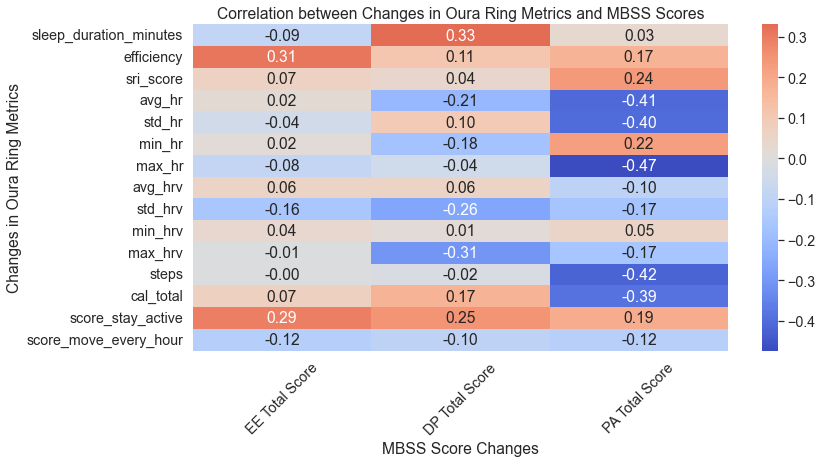

In [66]:
# Reload the Oura Ring data and preprocess it
oura_data = pd.read_csv("../Studies/oura_feats_bin01_23.csv")
# Replace Inf values with NaN to handle them together
oura_data.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Replace NaN values with the mean of each column
oura_data.fillna(oura_data.mean(numeric_only=True), inplace=True)

# Convert the 'date' column into ordinal numbers (number of days) for regression
oura_data['date'] = pd.to_datetime(oura_data['date'])
oura_data['date_ordinal'] = oura_data['date'].apply(lambda x: x.toordinal())

# Normalize the numeric features using z-score normalization
numeric_features = oura_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('date_ordinal')  # Remove 'date_ordinal' from the list of numeric features to normalize
oura_data[numeric_features] = oura_data[numeric_features].apply(stats.zscore)

# Re-calculate the slopes after normalization
feature_trends = {'participant_id': []}

for participant_id, group in oura_data.groupby('participant_id'):
    feature_trends['participant_id'].append(participant_id)
    for feature in numeric_features:
        # Skip the date ordinal feature
        if feature == 'date_ordinal':
            continue
        
        # Apply linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(group['date_ordinal'], group[feature])
        
        # Store the slope
        feature_trends.setdefault(feature, []).append(slope)

# Convert the dictionary to a DataFrame
trends_df = pd.DataFrame(feature_trends)

# Display the trends DataFrame
trends_df.head()

# Calculate the changes in MBSS scores from baseline to follow-up for each participant
mbss_baseline = mbss_data[mbss_data['Time Point'] == 'Baseline'].set_index('ID')
mbss_follow_up = mbss_data[mbss_data['Time Point'] == 'Follow Up'].set_index('ID')

# We assume that each participant has one baseline and one follow-up entry
mbss_score_changes = (mbss_follow_up[['EE Total Score', 'DP Total Score', 'PA Total Score']] - 
                      mbss_baseline[['EE Total Score', 'DP Total Score', 'PA Total Score']])

# Merge the overall trend in Oura features with the MBSS score changes
trend_correlation_data = trends_df.merge(mbss_score_changes, left_on="participant_id", right_index=True)

# Calculate the correlation between the trends in physiological features and the changes in MBSS scores
trend_correlation_matrix = trend_correlation_data.corr()

# Focus on the correlation between the overall trends in Oura Ring features and the MBSS score changes
trend_correlation_matrix.loc[numeric_columns, ['EE Total Score', 'DP Total Score', 'PA Total Score']]

plt.figure(figsize=(12, 6))
sns.heatmap(trend_correlation_matrix.loc[numeric_columns, ['EE Total Score', 'DP Total Score', 'PA Total Score']],
            annot=True, fmt=".2f", cmap='coolwarm', center=0)

# Add labels and title to the heatmap
plt.title('Correlation between Changes in Oura Ring Metrics and MBSS Scores')
plt.xlabel('MBSS Score Changes')
plt.ylabel('Changes in Oura Ring Metrics')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the heatmap
plt.show()

In [65]:
trends_df

,participant_id,sleep_duration_minutes,efficiency,sri_score,avg_hr,std_hr,min_hr,max_hr,avg_hrv,std_hrv,min_hrv,max_hrv,steps,cal_total,score_stay_active,score_move_every_hour
0,BIN01,-0.054849,-0.008512,0.019543,-0.017804,-0.016437,0.007682,-0.022261,0.019412,0.021386,0.001578,0.022048,0.002689,-0.003982,0.022438,-0.019665
1,BIN02,0.004997,0.018841,0.045889,-0.036647,-0.062635,0.016739,-0.071724,-0.012422,-0.014098,-0.001343,-0.008316,-0.035230,-0.022253,0.020341,0.003690
2,BIN03,-0.004678,-0.000742,0.036872,0.000309,-0.007442,0.002387,-0.031156,-0.005903,-0.003585,-0.000723,-0.006489,-0.001091,-0.002056,0.008725,0.006048
3,BIN04,-0.020000,-0.006072,0.028618,0.003221,-0.026875,0.018029,-0.019232,0.001056,0.004560,0.000288,0.003408,-0.012090,-0.007530,0.016873,0.010749
4,BIN05,0.001754,-0.041525,0.022110,-0.014238,0.019560,-0.052323,-0.023421,0.004365,0.013548,-0.012615,0.011742,-0.013297,-0.007030,0.036157,0.001691
5,BIN06,-0.004009,0.017613,0.025110,0.002293,0.004862,0.004590,0.005990,0.015373,-0.010176,-0.000767,0.004145,-0.000835,0.003132,-0.017824,-0.029049
6,BIN07,-0.013271,0.043731,0.030372,0.001575,-0.010644,0.035082,-0.000071,0.006697,0.012345,0.000002,0.018066,0.003809,-0.000688,-0.010373,-0.014414
7,BIN08,-0.005007,0.006398,0.028187,-0.016248,-0.010577,0.004469,-0.020229,0.010051,-0.007847,0.012100,-0.003929,-0.005073,-0.004363,-0.007604,0.023124
8,BIN09,-0.003678,-0.023737,0.019411,0.005818,-0.033606,0.043640,0.006397,-0.033520,-0.027581,-0.002986,-0.029777,0.021746,0.008198,0.009723,0.006730
9,BIN10,-0.000962,-0.005978,0.033012,-0.004036,-0.017834,0.007926,-0.015770,-0.003475,-0.011056,-0.000275,-0.009476,-0.033541,-0.012749,-0.029544,-0.008317
